In [67]:
import numpy as np
import matplotlib.pyplot as plt
import jlinops

import numpy as np
import math
from scipy.fft import dstn as sp_dstn
from scipy.fft import idstn as sp_idstn
from scipy.sparse.linalg import LinearOperator
# from scipy.sparse.linalg._interface import _CustomLinearOperator


from jlinops import _CustomLinearOperator, DiagonalOperator, get_device

# from ..base import _CustomLinearOperator
# from ..diagonal import DiagonalOperator
# from ..util import get_device

from jlinops import CUPY_INSTALLED
# from .. import CUPY_INSTALLED
if CUPY_INSTALLED:
    import cupy as cp
    from cupyx.scipy.fft import dctn as cp_dctn
    from cupyx.scipy.fft import idctn as cp_idctn


# Definitions

In [87]:
class DST2D(_CustomLinearOperator):
    """Represents a 2-dimensional DST transform.
    """
    def __init__(self, grid_shape, device="cpu", type=1):
        
        # Handle shape
        self.grid_shape = grid_shape
        n = math.prod(self.grid_shape)
        self.type = type
        shape = (n,n)
        
        if device == "cpu":
            
            def _matvec(x):
                return sp_dstn( x.reshape(self.grid_shape), norm="ortho", type=self.type ).flatten()
            
            def _rmatvec(x):
                return sp_idstn( x.reshape(self.grid_shape), norm="ortho", type=self.type ).flatten()
            
        else:
            
            def _matvec(x):
                return cp_dctn( x.reshape(self.grid_shape), norm="ortho", ).flatten()
            
            def _rmatvec(x):
                return cp_idctn( x.reshape(self.grid_shape), norm="ortho" ).flatten()
              
        super().__init__(shape, _matvec, _rmatvec, device=device)
        
    
    def to_gpu(self):
        return DST2D(self.grid_shape, device="gpu")
    
    def to_cpu(self):
        return DST2D(self.grid_shape, device="cpu")
    
    
    
def dst_get_eigvals(A, grid_shape, make_pos=False, type=1):
    """Given an SSPD LinearOperator A that is diagonalized by the 2-dimensional DST, computes its eigenvalues.
    """
    # Shape of dct
    M, N = grid_shape
    
    device = A.device
    if device == "cpu":
        v = np.random.normal(size=(M,N)) + 10.0
        #v = np.ones((M,N))
        tmp = A @ ( sp_idstn( v, norm="ortho", type=type ).flatten()  )
        tmp = tmp.reshape((M,N))
        tmp = sp_dstn( tmp, norm="ortho", type=type ).flatten()
        res = tmp/v.flatten()
        if make_pos:
            res = np.abs(res)
        return res
    else:
        v = cp.random.normal(size=(M,N)) + 10.0
        #v = cp.ones((M,N))
        tmp = A @ ( cp_idctn( v, norm="ortho", type=type ).flatten()  )
        tmp = tmp.reshape((M,N))
        tmp = cp_dctn( tmp, norm="ortho", type=type ).flatten()
        res = tmp/v.flatten()
        if make_pos:
            res = cp.abs(res)
        return res

    

def dst_sqrt(A, grid_shape, type=1):
    """Given a LinearOperator A that is diagonalized by the 2-dimensional DST, performs the diagonalization (computes 
    eigenvalues), computes the square root L in A = L L^T, and returns a LinearOperator representing L.
    """
    
    # Get eigenvalues
    eigvals = dst_get_eigvals(A, grid_shape, make_pos=True, type=type)
    
    # Setup 
    device = get_device(eigvals)
    P = DST2D(grid_shape, device=device, type=type)
    sqrt_lam = DiagonalOperator( eigvals**0.5 )
    sqrt_op = P.T @ sqrt_lam
    
    return sqrt_op



def dst_pinv(A, grid_shape, eps=1e-14, type=1):
    """Given a LinearOperator A that is diagonalized by the DST, performs the diagonalization (computes eigenvalues), returns a LinearOperator representing A^\dagger (pseudoinverse).
    """
    # Get eigenvalues
    eigvals = dst_get_eigvals(A, grid_shape, type=type)
    device = get_device(eigvals)

    # Take reciprocals of nonzero eigenvalues
    if device == "cpu":
        recip_eigvals = np.where( np.abs(eigvals) < eps, eigvals, 1.0 / np.clip(eigvals, a_min=eps, a_max=None) )
        recip_eigvals = np.where( np.abs(eigvals) < eps, np.zeros_like(eigvals), recip_eigvals )
    else:
        recip_eigvals = cp.where( cp.abs(eigvals) < eps, eigvals, 1.0 / cp.clip(eigvals, a_min=eps, a_max=None) )
        recip_eigvals = cp.where( cp.abs(eigvals) < eps, cp.zeros_like(eigvals), recip_eigvals )
    
    # DCT op
    P = DST2D(grid_shape, device=device, type=type)
    
    # Apinv op
    Apinv = P.T @ ( DiagonalOperator(recip_eigvals) @ P)
    
    return Apinv


def dct_sqrt_pinv(A, grid_shape, eps=1e-14, type=1):
    """Given an SSPD LinearOperator A that is diagonalized by the DST, performs the diagonalization (computes eigenvalues),
    computes the square root L in A = L L^T, and returns a LinearOperator representing L^\dagger (pseudoinverse).
    """
    # Get eigenvalues
    eigvals = dst_get_eigvals(A, grid_shape, make_pos=True, type=type)
    device = get_device(eigvals)

    # Take reciprocals of nonzero eigenvalues
    if device == "cpu":
        recip_eigvals = np.where( np.abs(eigvals) < 1e-14, eigvals, 1.0 / np.clip(eigvals, a_min=eps, a_max=None) )
        recip_eigvals = np.where( np.abs(eigvals) < 1e-14, np.zeros_like(eigvals), recip_eigvals )
    else:
        recip_eigvals = cp.where( cp.abs(eigvals) < 1e-14, eigvals, 1.0 / cp.clip(eigvals, a_min=eps, a_max=None) )
        recip_eigvals = cp.where( cp.abs(eigvals) < 1e-14, cp.zeros_like(eigvals), recip_eigvals )
    
    # DCT op
    P = DST2D(grid_shape, device=device, type=type)
    
    # Lpinv op
    Lpinv = DiagonalOperator(recip_eigvals**0.5) @ P

    return Lpinv

In [94]:
grid_shape = (5, 9)
R = jlinops.Dirichlet2DSym(grid_shape)
A = R.T @ R

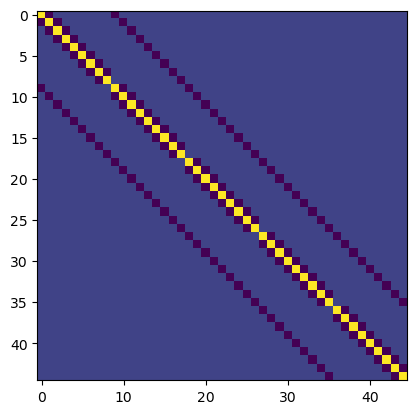

In [95]:
plt.imshow(jlinops.black_box_to_dense(A))
plt.show()

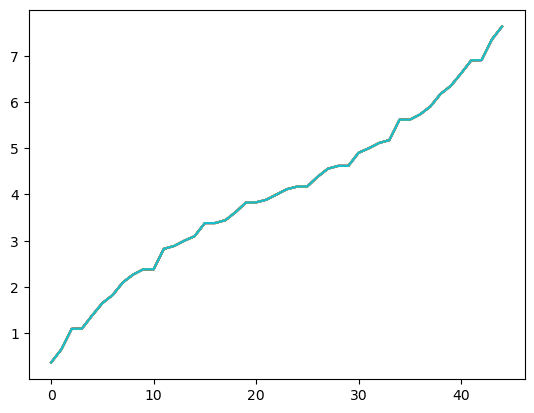

In [105]:
for j in range(10):
    eigvals = dst_get_eigvals(A, grid_shape, make_pos=False, type=1)
    z = np.sort(eigvals)
    #print(z)
    plt.plot(z)

plt.show()